# **CONNECTION AND CONFIGURATION**

In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Fri Feb  3 14:22:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Conecting with google drive
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive


Mounted at /content/gdrive


## *Clone, configure & compile Darknet*


In [3]:
# Clone repository
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15502, done.
remote: Total 15502 (delta 0), reused 0 (delta 0), pack-reused 15502
Receiving objects: 100% (15502/15502), 14.15 MiB | 21.75 MiB/s, done.
Resolving deltas: 100% (10404/10404), done.


In [4]:
# Configure
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [5]:
# Compile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
  946 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
 1147 |             if (iteration_old == 0)
      |

###*Configure yolov4.cfg file*

Yolov4 for training in custom data, requires a configuration file. 
For this we copy the configuration file and make some changes including the number of classes to train for.

*   change line max_batches to classes*2000, not less than number of training images and ideally not less than 6000.
*   set network size width=416 height=416 or any value multiple of 32
*   change line classes=80 to your number of objects in each of 3 [yolo]-layers
*   change [filters=255] to filters=(classes + 5)x3 in the 3 [convolutional] before each [yolo] layer, keep in mind that it only has to be the last [convolutional] before each of the [yolo] layers







In [6]:
# Make a copy of yolov4.cfg
!cp cfg/yolov4.cfg cfg/yolov4-custom.cfg

In [7]:
# Change lines in yolov4.cfg file
!sed -i 's@batch=64@batch=20@' cfg/yolov4-custom.cfg
!sed -i 's@subdivisions=8@subdivisions=16@' cfg/yolov4-custom.cfg
!sed -i 's@max_batches = 500500@max_batches = 2000@' cfg/yolov4-custom.cfg
!sed -i 's@width=608@width=416@' cfg/yolov4-custom.cfg
!sed -i 's@height=608@height=416@' cfg/yolov4-custom.cfg
!sed -i 's@steps=400000,450000@steps=1600,1800@' cfg/yolov4-custom.cfg
!sed -i '968 s@classes=80@classes=1@' cfg/yolov4-custom.cfg
!sed -i '1056 s@classes=80@classes=1@' cfg/yolov4-custom.cfg
!sed -i '1144 s@classes=80@classes=1@' cfg/yolov4-custom.cfg
!sed -i '961 s@filters=255@filters=18@' cfg/yolov4-custom.cfg
!sed -i '1049 s@filters=255@filters=18@' cfg/yolov4-custom.cfg
!sed -i '1137 s@filters=255@filters=18@' cfg/yolov4-custom.cfg

####Option for yolov4-tiny

In [ ]:
# Make a copy of yolov4.cfg for tiny model
#!cp cfg/yolov4-tiny.cfg cfg/yolov4-tiny-custom.cfg

In [ ]:
# Changes lines in yolov4-tiny.cfg
"""
!sed -i 's@batch=64@batch=20@' cfg/yolov4-tiny-custom.cfg
!sed -i 's@subdivisions=1@subdivisions=16@' cfg/yolov4-tiny-custom.cfg
!sed -i 's@max_batches = 2000200@max_batches = 6000@' cfg/yolov4-tiny-custom.cfg
!sed -i 's@width=608@width=416@' cfg/yolov4-tiny-custom.cfg
!sed -i 's@height=608@height=416@' cfg/yolov4-tiny-custom.cfg
!sed -i 's@steps=1600000,1800000@steps=1600,1800@' cfg/yolov4-tiny-custom.cfg
!sed -i '280 s@classes=80@classes=1@' cfg/yolov4-tiny-custom.cfg
!sed -i '229 s@classes=80@classes=1@' cfg/yolov4-tiny-custom.cfg
!sed -i '274 s@filters=255@filters=18@' cfg/yolov4-tiny-custom.cfg
!sed -i '221 s@filters=255@filters=18@' cfg/yolov4-tiny-custom.cfg
"""

###*Create .names and .data files*

Create file obj.names in the directory .\darknet\data\, with objects names(each in new line)

Create file obj.data in the directory .\darknet\data\, containing (where classes = number of objects): 
* classes = 1
* train  = data/train.txt
* valid  = data/test.txt
* names = data/obj.names
* backup = path to backup/

In [8]:
!echo -e 'maiz14' > data/obj.names
!echo -e 'classes= 1\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov4/run' > data/obj.data

###*Save configuration files in Google drive*

In [ ]:
save_path = '/mydrive/yolov4/run'
!cp /content/darknet/cfg/yolov4-custom.cfg {save_path}/yolov4-custom.cfg 
!cp data/obj.names /mydrive/yolov4/classes.txt


####Option for yolov4-tiny

In [ ]:
#!cp /content/darknet/cfg/yolov4-tiny-custom.cfg /mydrive/yolov4/yolov4-tiny-custom.cfg 
#!cp data/obj.names /mydrive/yolov4/classes.txt

#**DATASET**

Put image-files (.jpg) of your objects in the directory .\darknet\data\obj\

You should label each object on images from your dataset. Use this visual GUI-software for marking bounded boxes of objects and generating annotation files. It will create .txt-file for each .jpg-image-file - in the same directory and with the same name, but with .txt-extension

Sabe your dataset into a ZIP file into Drive

* Train: image.zip

* Test: test_images.zip

Dataset format
* Train (image and label) : img01.jpg, img01.txt

* Val  (image and label) : img10.jpg,  img10.txt


In [9]:
image_path = '/content/gdrive/MyDrive/yolov4'

In [10]:
%cd /content/darknet
!mkdir data/obj
!unzip {image_path}/images.zip -d data/obj  

/content/darknet
Archive:  /content/gdrive/MyDrive/yolov4/images.zip
  inflating: data/obj/images/m13-m14-0000.jpg  
  inflating: data/obj/images/m13-m14-0000.txt  
  inflating: data/obj/images/m13-m14-0022.jpg  
  inflating: data/obj/images/m13-m14-0022.txt  
  inflating: data/obj/images/m13-m14-0025.jpg  
  inflating: data/obj/images/m13-m14-0025.txt  
  inflating: data/obj/images/m13-m14-0031.jpg  
  inflating: data/obj/images/m13-m14-0031.txt  
  inflating: data/obj/images/m13-m14-0034.jpg  
  inflating: data/obj/images/m13-m14-0034.txt  
  inflating: data/obj/images/m13-m14-0040.jpg  
  inflating: data/obj/images/m13-m14-0040.txt  
  inflating: data/obj/images/m13-m14-0043.jpg  
  inflating: data/obj/images/m13-m14-0043.txt  
  inflating: data/obj/images/m13-m14-0046.jpg  
  inflating: data/obj/images/m13-m14-0046.txt  
  inflating: data/obj/images/m13-m14-0049.jpg  
  inflating: data/obj/images/m13-m14-0049.txt  
  inflating: data/obj/images/m13-m14-0052.jpg  
  inflating: data/o

For validation

In [11]:
!mkdir data/val
!unzip {image_path}/test_images.zip -d data/val

Archive:  /content/gdrive/MyDrive/yolov4/test_images.zip
  inflating: data/val/test_images/m13-m14-0028.jpg  
  inflating: data/val/test_images/m13-m14-0028.txt  
  inflating: data/val/test_images/m13-m14-0037.jpg  
  inflating: data/val/test_images/m13-m14-0037.txt  
  inflating: data/val/test_images/m13-m14-0064.jpg  
  inflating: data/val/test_images/m13-m14-0064.txt  
  inflating: data/val/test_images/m13-m14-0097.jpg  
  inflating: data/val/test_images/m13-m14-0097.txt  
  inflating: data/val/test_images/m13-m14-0196.jpg  
  inflating: data/val/test_images/m13-m14-0196.txt  
  inflating: data/val/test_images/m13-m14-0239.jpg  
  inflating: data/val/test_images/m13-m14-0239.txt  
  inflating: data/val/test_images/m13-m14-0396.jpg  
  inflating: data/val/test_images/m13-m14-0396.txt  
  inflating: data/val/test_images/m13-m14-1027.jpg  
  inflating: data/val/test_images/m13-m14-1027.txt  
  inflating: data/val/test_images/m13-m14-1221.jpg  
  inflating: data/val/test_images/m13-m14-

##*Create train.txt and test.txt file*

Create file train.txt in directory .\darknet\data\, with filenames of your images, each filename in new line, with path relative to darknet.exe

In [12]:
import glob
images_list = glob.glob("data/obj/images/*.jpg")
with open("data/train.txt", "w") as f:
    f.write("\n".join(images_list))

Create test.txt

In [13]:
test_list = glob.glob("data/val/test_images/*.jpg")
with open("data/test.txt", "w") as f:
    f.write("\n".join(test_list))

In [31]:
import os
print("Number of training images:", len(os.listdir('/content/darknet/data/obj/images'))/2)
print("Number of validation images:", len(os.listdir('/content/darknet/data/val/test_images'))/2)

Number of training images: 308.0
Number of validation images: 13.0


#**PRETRAINED WEIGHTS**

Download pre-trained weights for the convolutional layers and put to the directory .\darknet

In [ ]:
%cd /content/darknet
! gdown https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

/content/darknet
Downloading...
From: https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137
To: /content/darknet/yolov4.conv.137
100% 170M/170M [00:05<00:00, 29.7MB/s]


#**TRAIN**

In [ ]:
#Inicial training
!./darknet detector train data/obj.data cfg/yolov4-custom.cfg /content/darknet/yolov4.conv.137 -dont_show -i 0 -map

# Uncomment below and comment above to re-start your training from last saved weights
#!./darknet detector train data/obj.data cfg/yolov4-custom.cfg {save_path}/yolov4-custom_last.weights -dont_show -i 0 -map

#For yolov4-tiny 
#!./darknet detector train data/obj.data cfg/yolov4-tiny-custom.cfg /mydrive/yolov4/yolov4-tiny.conv.29 -dont_show -i 0 -map
# Uncomment below and comment above to re-start your training from last saved weights
#!./darknet detector train data/obj.data cfg/yolov4-tiny-custom.cfg /mydrive/yolov4/yolov4-tiny-custom_best.weights -dont_show -i 0 -map

Streaming output truncated to the last 5000 lines.
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.000000), count: 1, class_loss = 0.000556, iou_loss = 0.000000, total_loss = 0.000556 
 total_bbox = 703285, rewritten_bbox = 0.209303 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.498223), count: 10, class_loss = 12.336407, iou_loss = 44.234364, total_loss = 56.570770 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.565287), count: 15, class_loss = 15.329086, iou_loss = 26.403751, total_loss = 41.732838 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.581480), count: 1, class_loss = 0.735325, iou_loss = 0.207264, total_loss = 0.942589 
 total_bbox = 703311, rewritten_bbox = 0.209296 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.702960), count: 4, class_loss = 3.600148, iou_loss = 53.675743, total_loss = 57.

#**METRICS**

mAP (mean average precision) - mean value of average precisions for each class, where average precision is average value of 11 points on PR-curve for each possible threshold (each probability of detection) for the same class (Precision-Recall in terms of PascalVOC, where Precision=TP/(TP+FP) and Recall=TP/(TP+FN) )
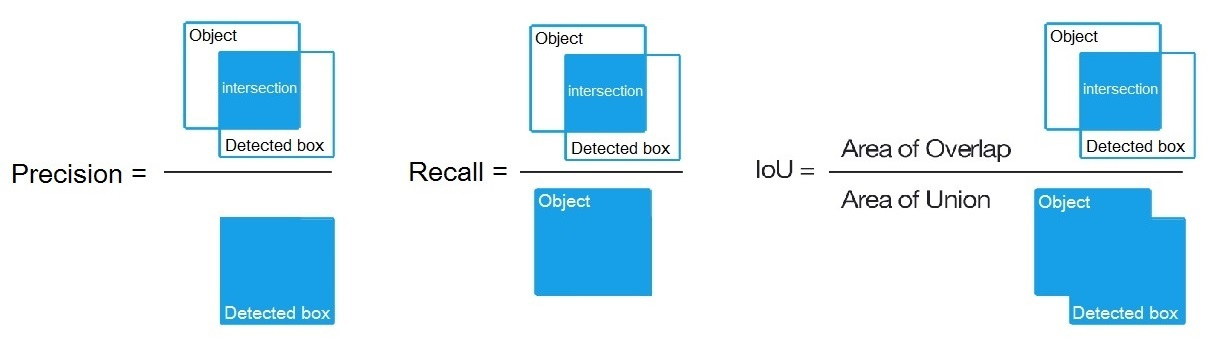

In [14]:
# define helper functions to show images
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

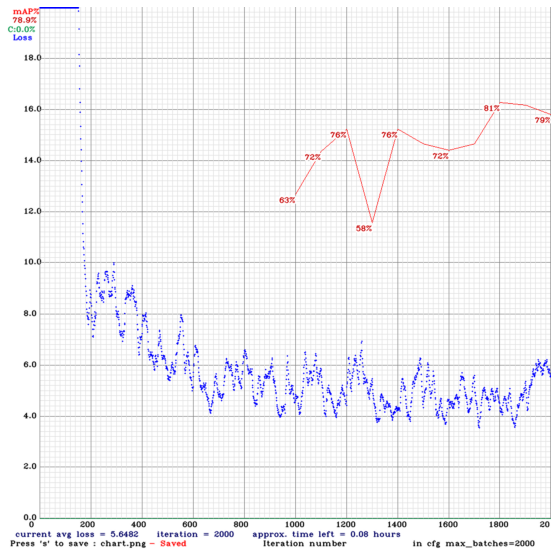

In [ ]:
imShow( '/content/darknet/chart.png')

In [ ]:
#copy into drive
!cp /content/darknet/chart.png {save_path}/chart_yolov4-custom.png

In [ ]:
#!cp /content/darknet/chart_yolov4-tiny-custom.png /mydrive/yolov4/chart_yolov4-tiny-custom2.png

#**DETECTION**

In [15]:
#coco.names is hardcoded somewhere in the detector
%cp data/obj.names data/coco.names

In [16]:
import os

In [22]:
#data/valt has images that we can test our detector on
test_images = [f for f in os.listdir('/content/darknet/data/val/test_images') if f.endswith('.jpg')]
import random
img_path = "data/val/test_images/" + random.choice(test_images);

#test out our detector!
!./darknet detect /mydrive/yolov4/run/yolov4-custom.cfg /mydrive/yolov4/run/yolov4-custom_best.weights {img_path} -dont-show


 CUDA-version: 11020 (11060), cuDNN: 8.1.1, GPU count: 1  
 OpenCV version: 4.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv     64       1 x 1/ 1    208 x

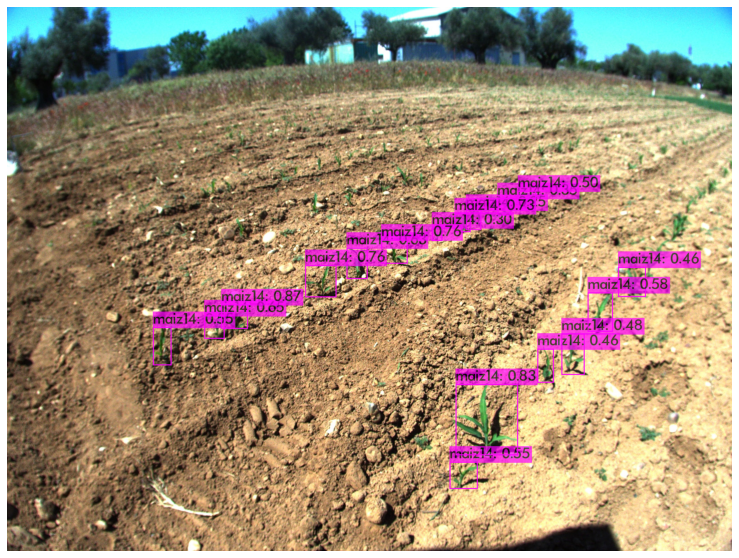

In [23]:
imShow('/content/darknet/predictions.jpg')
